# **Import Libraries**

In [1]:
!pip install tensorflow==2.12.0 protobuf==3.20.3

  Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl.metadata (2.5 kB)
  Using cached tensorflow_intel-2.12.0-cp39-cp39-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl (1.9 kB)
Using cached tensorflow_intel-2.12.0-cp39-cp39-win_amd64.whl (272.8 MB)

  Attempting uninstall: tensorflow-intel

    Found existing installation: tensorflow-intel 2.17.0

   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   -

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\dell\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\tensorflow\\__init__.py'



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import joblib
from wordcloud import WordCloud
from keras.models import Sequential
from keras.layers import Dense
sns.set(style="darkgrid")


# **Load dataset & initial inspect**



In [3]:
df = pd.read_csv('fakejobposting.csv', low_memory=False)
print("Shape:", df.shape)
display(df.head())
display(df.info())

Shape: (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

None

In [4]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


# **Basic cleaning (drop unused cols, handle target)**

In [5]:
# drop columns not needed (if present)
cols_to_drop = [c for c in ['job_id','salary_range'] if c in df.columns]
if cols_to_drop:
    df.drop(cols_to_drop, axis=1, inplace=True)

In [6]:
# Fill NA in text columns with empty string (so concat safe)
df.fillna('', inplace=True)

In [7]:
# Keep only valid target values 0/1 and convert to int
df = df[df['fraudulent'].isin([0,1])]
df['fraudulent'] = df['fraudulent'].astype(int)

In [8]:
df.isna().sum()

title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [9]:
df.head(5)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [10]:
# Clean the target column (remove blank or invalid entries)
df = df[df['fraudulent'].isin([0, 1])]

# Convert to integer type
df['fraudulent'] = df['fraudulent'].astype(int)

print("\nCleaned target column distribution:")
print(df['fraudulent'].value_counts())



Cleaned target column distribution:
fraudulent
0    17014
1      866
Name: count, dtype: int64


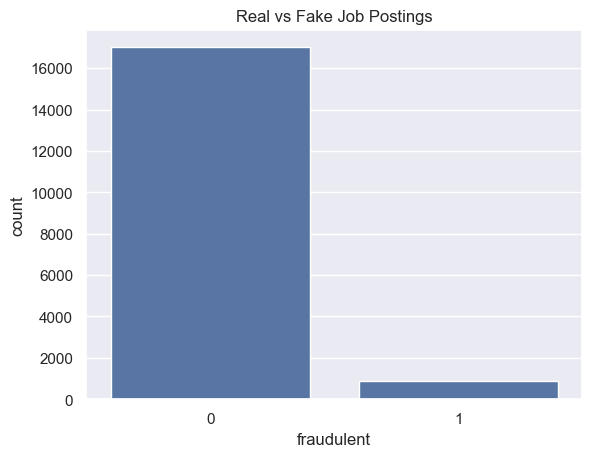

In [11]:
# Visualize class balance
sns.countplot(x='fraudulent', data=df)
plt.title("Real vs Fake Job Postings")
plt.show()

# **Combine textual columns into single text column**

In [12]:
text_cols = ['title', 'location', 'company_profile', 'description', 'requirements', 'benefits']
df['text'] = df[text_cols].apply(lambda x: ' '.join(x), axis=1)
df = df[['text', 'fraudulent']]

print(df.head())
print(df.info())

                                                text  fraudulent
0  Marketing Intern US, NY, New York We're Food52...           0
1  Customer Service - Cloud Video Production NZ, ...           0
2  Commissioning Machinery Assistant (CMA) US, IA...           0
3  Account Executive - Washington DC US, DC, Wash...           0
4  Bill Review Manager US, FL, Fort Worth SpotSou...           0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        17880 non-null  object
 1   fraudulent  17880 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 209.7+ KB
None


# **NLP preprocessing (cleaning + lemmatize)**

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [14]:
!pip uninstall -y nltk
!pip install nltk

Found existing installation: nltk 3.8.1
Uninstalling nltk-3.8.1:
  Successfully uninstalled nltk-3.8.1
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 3.4 MB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.5 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.5 MB/s  0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.2 which is incompatible.


In [15]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [16]:
# Clean text function (fixed warnings)
def clean_text(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub(r'\[[^]]*\]', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()

    # Remove stopwords
    stop = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop])

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

# Apply cleaning
df['text'] = df['text'].apply(clean_text)

display(df[['text', 'fraudulent']].head())

C:\Users\DELL\AppData\Local\Temp\ipykernel_4676\1958423037.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,text,fraudulent
0,marketing intern u ny new york food weve creat...,0
1,customer service cloud video production nz auc...,0
2,commissioning machinery assistant cma u ia wev...,0
3,account executive washington dc u dc washingto...,0
4,bill review manager u fl fort worth spotsource...,0


# visualize data

(-0.5, 1599.5, 799.5, -0.5)

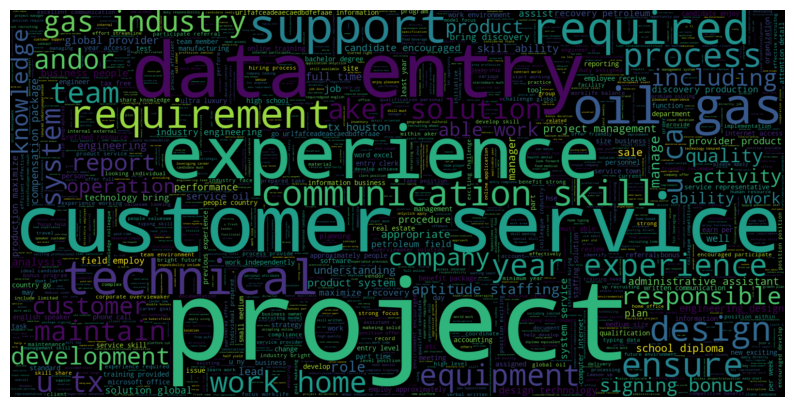

In [17]:
plt.figure(figsize=(10, 6))
wc = WordCloud(max_words=3000, width=1600, height=800).generate(" ".join(df[df.fraudulent == 1].text))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

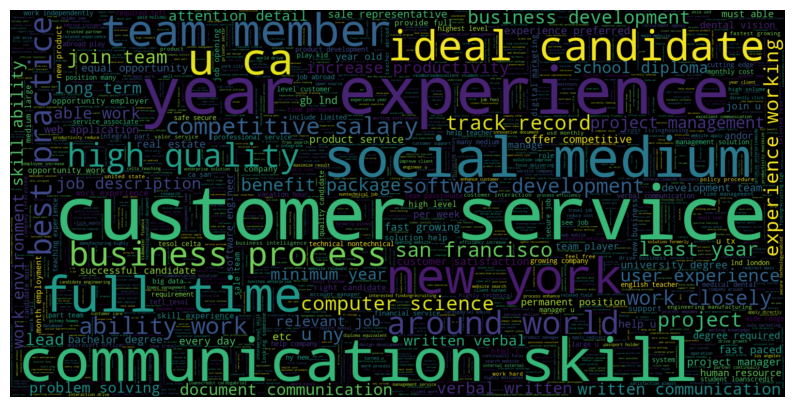

In [18]:
plt.figure(figsize=(10, 6))
wc = WordCloud(max_words=3000, width=1600, height=800).generate(" ".join(df[df.fraudulent == 0].text))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

<Axes: xlabel='fraudulent', ylabel='count'>

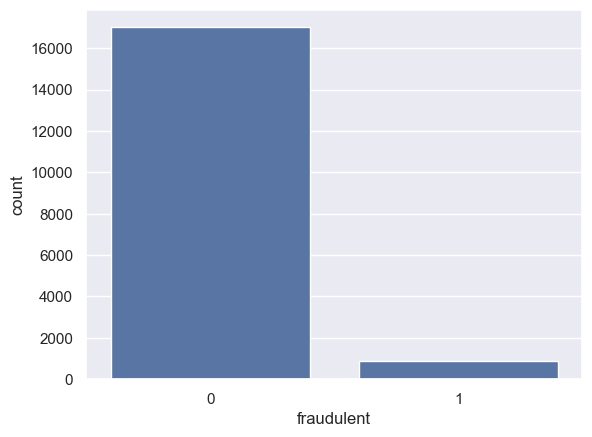

In [19]:
sns.set(style="darkgrid")
sns.countplot(x='fraudulent', data=df)

# **Train / Test split (text)**

In [20]:
X = df['text']
y = df['fraudulent']

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train size:", X_train_text.shape)
print("Test size:", X_test_text.shape)


Train size: (14304,)
Test size: (3576,)


# **TF-IDF vectorization**

In [21]:
tfidf = TfidfVectorizer(max_features=5000, min_df=5, ngram_range=(1,2))  # unigrams + bigrams
X_train_tfidf = tfidf.fit_transform(X_train_text)   # sparse matrix
X_test_tfidf  = tfidf.transform(X_test_text)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape: ", X_test_tfidf.shape)

# Save vectorizer for later use
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


X_train_tfidf shape: (14304, 5000)
X_test_tfidf shape:  (3576, 5000)


['tfidf_vectorizer.pkl']

# **Balance training data with SMOTE**

In [22]:
print("Before SMOTE:", y_train.value_counts().to_dict())

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

print("After SMOTE:", pd.Series(y_train_res).value_counts().to_dict())
print("X_train_res shape:", X_train_res.shape)


Before SMOTE: {0: 13611, 1: 693}
After SMOTE: {0: 13611, 1: 13611}
X_train_res shape: (27222, 5000)


# **Train 3 ML models (Logistic Regression, Naive Bayes, SVM) and evaluate**


--- Training Logistic Regression ---
Accuracy: 0.9748
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3403
           1       0.69      0.86      0.77       173

    accuracy                           0.97      3576
   macro avg       0.84      0.92      0.88      3576
weighted avg       0.98      0.97      0.98      3576



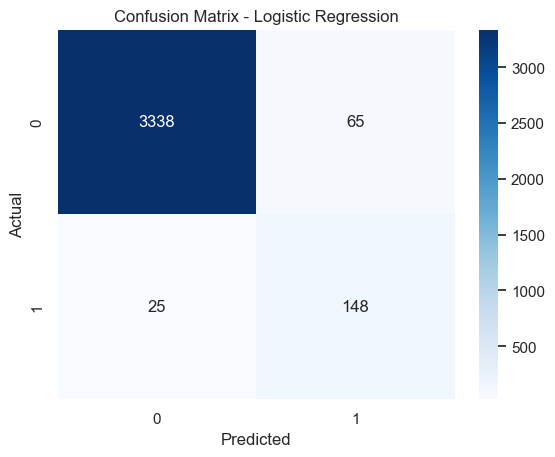


--- Training Naive Bayes ---
Accuracy: 0.9141
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3403
           1       0.35      0.91      0.51       173

    accuracy                           0.91      3576
   macro avg       0.67      0.91      0.73      3576
weighted avg       0.96      0.91      0.93      3576



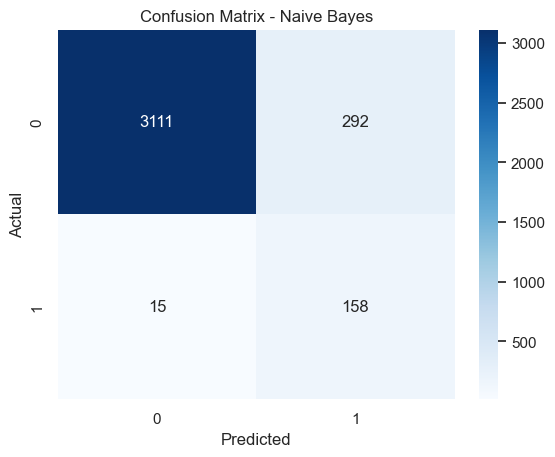


--- Training SVM (Linear) ---
Accuracy: 0.9829
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.81      0.84      0.83       173

    accuracy                           0.98      3576
   macro avg       0.90      0.91      0.91      3576
weighted avg       0.98      0.98      0.98      3576



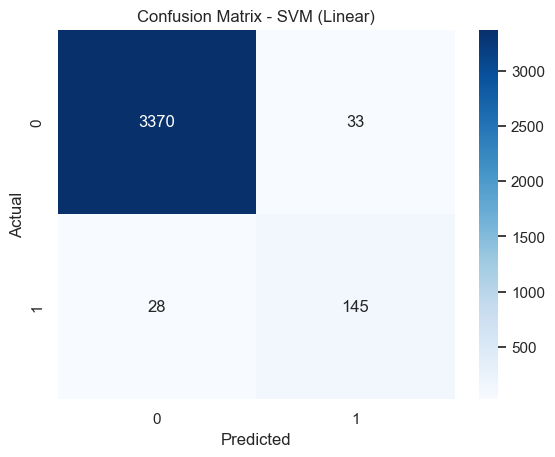

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.974832,0.694836,0.855491,0.766839,0.983836
1,Naive Bayes,0.914150,0.351111,0.913295,0.507223,0.974456
2,SVM (Linear),0.982942,0.814607,0.838150,0.826211,0.979401


In [23]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM (Linear)": SVC(kernel='linear', probability=True)
}

results = {}
detailed_metrics = []

for name, m in models.items():
    print(f"\n--- Training {name} ---")
    m.fit(X_train_res, y_train_res)
    y_pred = m.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, m.predict_proba(X_test_tfidf)[:,1]) if hasattr(m, "predict_proba") else roc_auc_score(y_test, m.decision_function(X_test_tfidf))

    results[name] = acc
    detailed_metrics.append([name, acc, prec, rec, f1, auc])

    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# summary df for ML models
ml_summary = pd.DataFrame(detailed_metrics, columns=['Model','Accuracy','Precision','Recall','F1','AUC'])
display(ml_summary)


# **Plot ML accuracies**

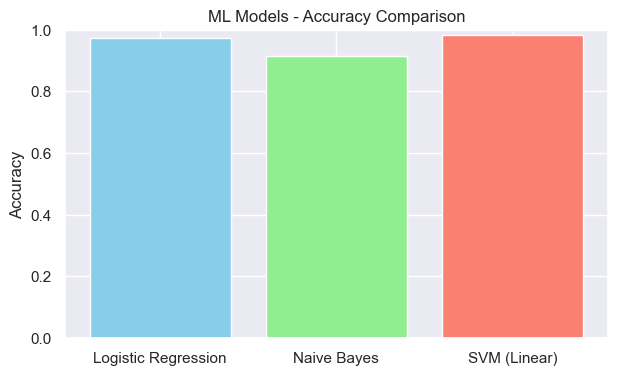

In [24]:
plt.figure(figsize=(7,4))
plt.bar(results.keys(), results.values(), color=['skyblue','lightgreen','salmon'])
plt.title("ML Models - Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


# **Build & train ANN (Keras)**

In [27]:
# Build ANN (call it ann_model to avoid name collision)
ann_model = Sequential()
ann_model.add(Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               640128    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 650,497
Trainable params: 650,497
Non-trainable params: 0
_________________________________________________________________


In [28]:
from sklearn.model_selection import train_test_split

X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train_res, y_train_res, test_size=0.2, random_state=42
)

# Convert only the parts you train with
X_train_part = X_train_part.toarray()
X_val_part = X_val_part.toarray()

history = ann_model.fit(
    X_train_part, y_train_part,
    validation_data=(X_val_part, y_val_part),
    epochs=5, batch_size=64, verbose=1
)


Epoch 1/5
341/341 [==============================] - 7s 15ms/step - loss: 0.0890 - accuracy: 0.9763 - val_loss: 0.0155 - val_accuracy: 0.9954
Epoch 2/5
341/341 [==============================] - 5s 15ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0246 - val_accuracy: 0.9932
Epoch 3/5
341/341 [==============================] - 5s 15ms/step - loss: 7.3901e-04 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 0.9963
Epoch 4/5
341/341 [==============================] - 5s 14ms/step - loss: 5.9962e-04 - accuracy: 0.9999 - val_loss: 0.0188 - val_accuracy: 0.9949
Epoch 5/5
341/341 [==============================] - 5s 14ms/step - loss: 3.3164e-04 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 0.9956


# **Evaluate ANN on test set**

112/112 [==============================] - 0s 3ms/step
ANN Accuracy: 0.9840604026845637
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.89      0.77      0.82       173

    accuracy                           0.98      3576
   macro avg       0.94      0.88      0.91      3576
weighted avg       0.98      0.98      0.98      3576



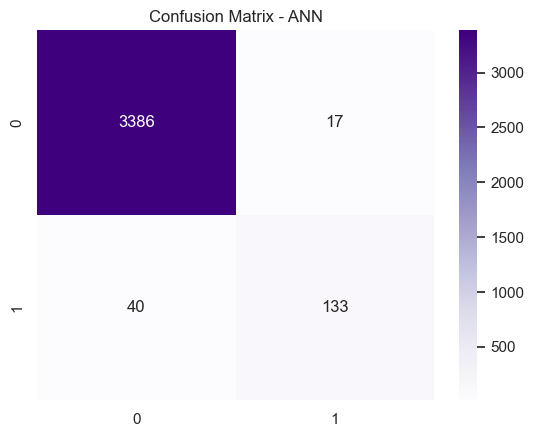

In [29]:
# ANN expects dense arrays for X_test — convert sparse -> dense
X_test_dense = X_test_tfidf.toarray()

y_prob_ann = ann_model.predict(X_test_dense).flatten()
y_pred_ann = (y_prob_ann > 0.5).astype(int)

acc_ann = accuracy_score(y_test, y_pred_ann)
prec_ann = precision_score(y_test, y_pred_ann, zero_division=0)
rec_ann  = recall_score(y_test, y_pred_ann, zero_division=0)
f1_ann   = f1_score(y_test, y_pred_ann, zero_division=0)
auc_ann  = roc_auc_score(y_test, y_prob_ann)

print("ANN Accuracy:", acc_ann)
print(classification_report(y_test, y_pred_ann, zero_division=0))
cm = confusion_matrix(y_test, y_pred_ann)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - ANN")
plt.show()


# **Comparative metrics table (ML vs ANN)**

,Model,Accuracy,Precision,Recall,F1,AUC
0,ANN (Keras),0.984060,0.886667,0.768786,0.823529,0.986488
1,SVM (Linear),0.982942,0.814607,0.838150,0.826211,0.979401
2,Logistic Regression,0.974832,0.694836,0.855491,0.766839,0.983836
3,Naive Bayes,0.914150,0.351111,0.913295,0.507223,0.974456


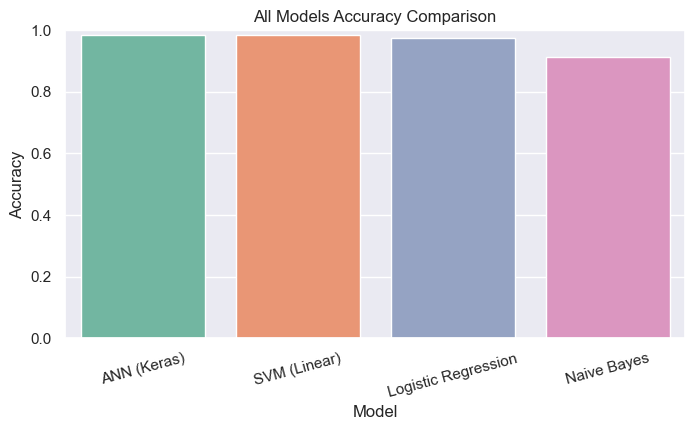

In [33]:
# collect metrics from previous ml_summary and ANN
comparison = ml_summary.copy()
new_row = pd.DataFrame([{
    'Model':'ANN (Keras)',
    'Accuracy': acc_ann,
    'Precision': prec_ann,
    'Recall': rec_ann,
    'F1': f1_ann,
    'AUC': auc_ann
}])

comparison = pd.concat([comparison, new_row], ignore_index=True)

# display sorted by accuracy
comparison = comparison.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
display(comparison)

plt.figure(figsize=(8,4))
sns.barplot(x='Model', y='Accuracy', hue='Model', data=comparison, palette='Set2', legend=False)
plt.ylim(0,1)
plt.title("All Models Accuracy Comparison")
plt.xticks(rotation=15)
plt.show()


# **ANN training curves (plot)**

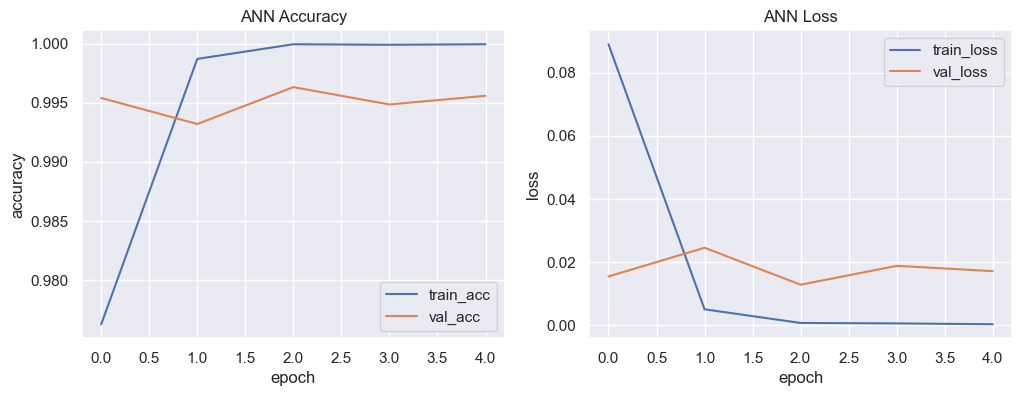

In [34]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('ANN Accuracy')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('ANN Loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()

plt.show()


# **Save models & artifacts**

In [32]:

# Save ML models and vectorizer
joblib.dump(models['Logistic Regression'], 'logistic_model.pkl')   # careful: 'models' dict was earlier used; if overwritten, reinitialize or save from trained objects
# If you want to save each trained model, do:
joblib.dump(models['Logistic Regression'], 'logistic_model.pkl')
joblib.dump(models['Naive Bayes'], 'nb_model.pkl')
joblib.dump(models['SVM (Linear)'], 'svm_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# Save ANN
ann_model.save('ann_model.h5')

# Save performance table
comparison.to_csv('model_comparison.csv', index=False)
